In [65]:
#importaciones
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy.stats import boxcox

In [64]:
dataframe = pd.read_csv("muestra4s.csv")
dataframe.head(5)

,id,sensor1,sensor2,sensor3,sensor4
0,388937,0.332645,0.312709,0.066802,0.223234
1,90665,0.114415,0.010050,0.043108,0.222393
2,62420,0.089782,0.154589,0.101575,0.090151
3,20018,0.242456,0.101617,0.063159,0.158376
4,57736,0.130230,0.067402,0.066449,0.141199


# EDA 
Como punto de partida inicial para el análisis exploratorio de los datos se utilizo el siguiente recurso de IBM: 
https://www.ibm.com/docs/es/spss-modeler/saas?topic=understanding-collecting-initial-data <br>
En esta fase inicial pretendemos responder preguntas como: <br>
- ¿Qué atributos (columnas) de la base de datos parecen más prometedores?
- ¿Qué atributos no parecen relevantes y se pueden excluir? 
- ¿Cómo se distribuyen los datos?
- ¿Qué tipo de técnicas tiene más sentido usar?

In [4]:
print("Renglones y columnas: " + str(dataframe.shape))
print("Data types: \n" + str(dataframe.dtypes))
print("Revisando nulos en el dataframe:\n " + str(dataframe.isnull().any()))

Renglones y columnas: (300, 5)
Data types: 
id           int64
sensor1    float64
sensor2    float64
sensor3    float64
sensor4    float64
dtype: object
Revisando nulos en el dataframe:
 id         False
sensor1    False
sensor2    False
sensor3    False
sensor4    False
dtype: bool


Podemos observar que tenemos un dataframe de 300 renglones y 5 columnas, donde todas las columnas menos el id son de tipo float y que no contamos con valores nulos en el df

In [35]:
dataframe.describe()

,sensor1,sensor2,sensor3,sensor4
count,300.000000,300.000000,300.000000,300.000000
mean,0.203864,0.196685,0.198745,0.202088
std,0.130148,0.203096,0.218348,0.126481
min,0.013153,0.004468,0.004946,0.005244
25%,0.107719,0.059639,0.043634,0.105538
50%,0.178133,0.138402,0.115086,0.182516
75%,0.281055,0.254938,0.253272,0.278511
max,0.718866,0.949300,0.962168,0.566642


- Donde count nos indica que en ningún registro existen valores faltantes <br>
- Mean (media o promedio) nos muestra que todos los datos trabajan en un rango de valores entre 0.19 y 0.20 <br>
- std (desv. estandar) nos muestra que los sensores 2 y 3 son los que más variación presentan respecto a la media, esto puede afectar en las futuras técnicas de clustering que ocupemos
- min muestra los valores mínimos de cada sensor, los valores mínimos casi alcanzan el cero
- 25, 50 (o mediana) y 75 representan los cuartiles donde podemos ver que
    -  el 25% de los datos de los sensores 2 y 3 son valores muy bajos
    -  el Q2 o 50% o mediana es el valor central de los datos, podemos realizar una comparación entre el promedio y la mediana para ver si existe algún sesgo para los datos
    -  el tercer cuartil muestra que para el sensor 1 y 4 existe una cuarta parte de los datos con valores mayores a 0.28 y 0.27 respectivamente, lo que parece demostrar una disperción de valores
- max nos muestra los valores máximos de cada sensor, los sensores 2 y 3 muestran rangos parecidos entre mínimos y máximos, mientras que los sensores 1 y 4 tienen distribuciones completamente diferentes a todos los sensores
  


In [67]:
dataframe.drop("id", axis=1, inplace= True) # borrar col 1
dataframe.head(2)

,sensor1,sensor2,sensor3,sensor4
0,0.332645,0.312709,0.066802,0.223234
1,0.114415,0.010050,0.043108,0.222393


In [18]:
df_desc = dataframe.describe()
df_comparacion = pd.DataFrame({"promedio": dataframe.mean(),"mediana": dataframe.median()})
df_comparacion

,promedio,mediana
sensor1,0.203864,0.178133
sensor2,0.196685,0.138402
sensor3,0.198745,0.115086
sensor4,0.202088,0.182516


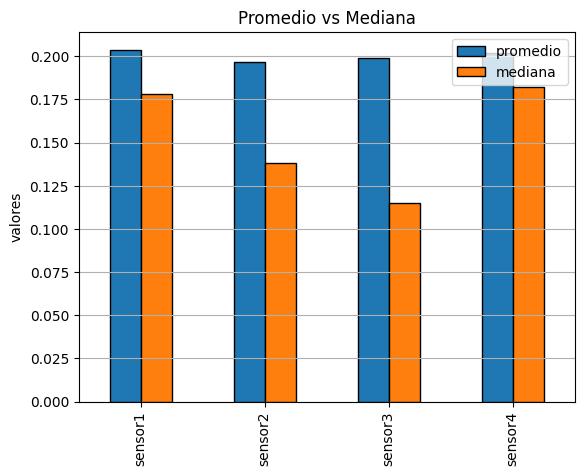

In [34]:
df_comparacion.plot(kind="bar",edgecolor = "black")
plt.title("Promedio vs Mediana")
plt.ylabel("valores")
plt.grid(axis="y")
plt.show()

In [27]:
df_skew = dataframe.skew()
df_skew

sensor1    1.018613
sensor2    1.639237
sensor3    1.547334
sensor4    0.829939
dtype: float64

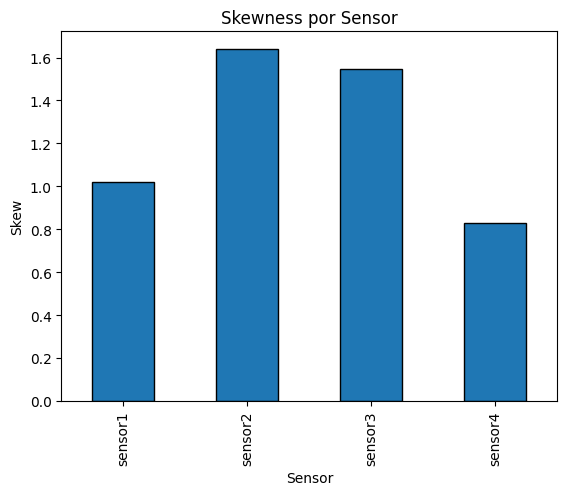

In [32]:
#plt.figure(figsize=(8,5))
df_skew.plot(kind='bar', edgecolor='black')
plt.title("Skewness por Sensor")
plt.ylabel("Skew")
plt.xlabel("Sensor")
plt.show()

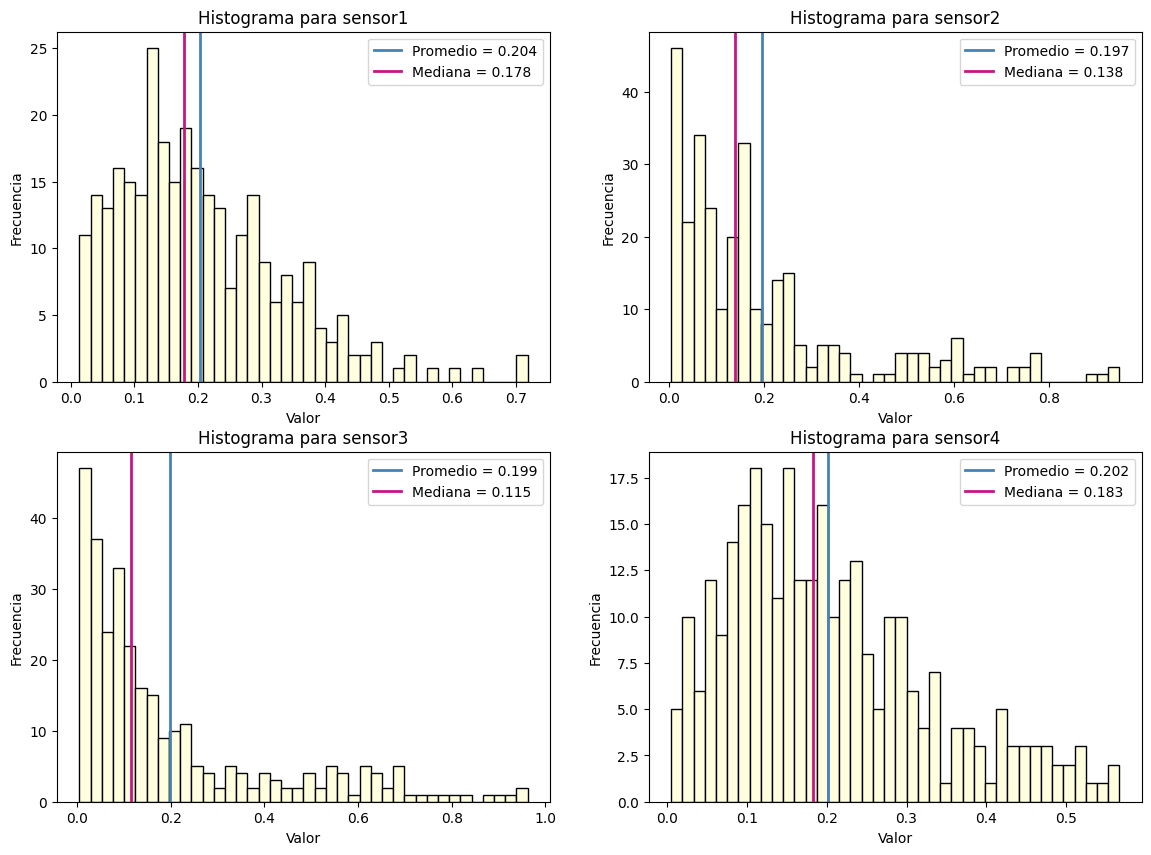

In [55]:
# columans a iterar
columnas = ["sensor1", "sensor2", "sensor3", "sensor4"]

plt.figure(figsize=(14, 10))

for i, col in enumerate(columnas, 1): # 1,sensor1;2,sensor2;...
    plt.subplot(2, 2, i)

    # histograma del sensor
    plt.hist(dataframe[col], bins=40, edgecolor='black', color='lightyellow') # bin = buckets o agrupamiento de datos en el hist

    # mean y q2 
    promedio = df_comparacion.loc[col, "promedio"]
    mediana = df_comparacion.loc[col, "mediana"]
    plt.axvline(promedio, color='steelblue', linewidth=2, label=f'Promedio = {promedio:.3f}') 
    plt.axvline(mediana, color='mediumvioletred', linewidth=2, label=f'Mediana = {mediana:.3f}')

    # textos
    plt.title(f"Histograma para {col}")
    plt.xlabel("Valor")
    plt.ylabel("Frecuencia")
    plt.legend()
    
plt.show()


## Conclusiones del EDA
1. Los valores observados en los sensores rondan entre el 0 y el 1 (0.004468 y 0.962168) pero la dispersión de datos es diferente para cada sensor <br>
2. La mediana es menor al promedio en todos los sensores lo que indica que el grado de asimetría (skewness) posee un sesgo positivo para todos los sensores (colas hacia la derecha) <br>
3. La desviación estandar y la dispersion de los datos en los sensores 2 y 3 es alta, hay que tener cuidado con los algoritmos que se apliquen, los sensores 1 y 4 son menos pronunciados pero aún poseen sesgos
4. No hay valores faltantes y el tipo de dato es igual para todos los valores<br>

# Transformaciones estadísticas

In [70]:
df = dataframe[['sensor1', 'sensor2', 'sensor3', 'sensor4']].copy()

## Normalización
Todos los datos ya se encuentran en un rango de valores cercano al 0 y el 1, además todos son del mismo tipo, por lo que aplicar un algoritmo como minmaxscaler no parece tener repercusiones importantes <br>
Al aplicar minmax podemos ver que las medianas, los cuartiles y las dispersiones se mantienen iguales; las medias se mueven proporcionalmente y las relaciones se mantienen iguales <br>
Esta transformación puede resultar positiva para los métodos de clustering que se van a aplciar <br>

In [76]:
df.describe()

,sensor1,sensor2,sensor3,sensor4
count,300.000000,300.000000,300.000000,300.000000
mean,0.203864,0.196685,0.198745,0.202088
std,0.130148,0.203096,0.218348,0.126481
min,0.013153,0.004468,0.004946,0.005244
25%,0.107719,0.059639,0.043634,0.105538
50%,0.178133,0.138402,0.115086,0.182516
75%,0.281055,0.254938,0.253272,0.278511
max,0.718866,0.949300,0.962168,0.566642


In [75]:
minmax_scaler = MinMaxScaler()
df_minmax = minmax_scaler.fit_transform(df)
df_minmax = pd.DataFrame(df_minmax, columns=df.columns)
df_minmax.describe()

,sensor1,sensor2,sensor3,sensor4
count,300.000000,300.000000,300.000000,300.000000
mean,0.270239,0.203440,0.202460,0.350631
std,0.184420,0.214955,0.228106,0.225297
min,0.000000,0.000000,0.000000,0.000000
25%,0.134000,0.058393,0.040418,0.178650
50%,0.233777,0.141755,0.115062,0.315769
75%,0.379618,0.265095,0.259424,0.486761
max,1.000000,1.000000,1.000000,1.000000


In [83]:
desc_original = df.describe()
desc_minmax = df_minmax.describe()
comparacion = pd.concat([desc_original.add_prefix("orig_"), desc_minmax.add_prefix("minmax_")],axis=1)
comparacion

,orig_sensor1,orig_sensor2,orig_sensor3,orig_sensor4,minmax_sensor1,minmax_sensor2,minmax_sensor3,minmax_sensor4
count,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000
mean,0.203864,0.196685,0.198745,0.202088,0.270239,0.203440,0.202460,0.350631
std,0.130148,0.203096,0.218348,0.126481,0.184420,0.214955,0.228106,0.225297
min,0.013153,0.004468,0.004946,0.005244,0.000000,0.000000,0.000000,0.000000
25%,0.107719,0.059639,0.043634,0.105538,0.134000,0.058393,0.040418,0.178650
50%,0.178133,0.138402,0.115086,0.182516,0.233777,0.141755,0.115062,0.315769
75%,0.281055,0.254938,0.253272,0.278511,0.379618,0.265095,0.259424,0.486761
max,0.718866,0.949300,0.962168,0.566642,1.000000,1.000000,1.000000,1.000000


## Estandarización 
"Una puntuación z representa el número de desviaciones estándar que un punto de datos se aleja de la media de su distribución" <br>
Con standard scaler vamos a buscar que cada columna tenga una media de 0 y una desviacion de 1 mientras preservamos la forma de la distribucion, es decir centrar la distribución normalizar la dispersión e igualar el peso estadístico entre las columnas <br>
Todo esto con el fin de buscar que ningún sensor domine y encontrar Clusters reales <br>

In [107]:
std_scaler = StandardScaler()
df_zscore = std_scaler.fit_transform(df)
df_zscore = pd.DataFrame(df_zscore , columns=df.columns)
print("-----Describe del dataframe escalado: -----")
display(df_zscore .describe())
print("-----Head del dataframe después de zscore: ------")
display(df_zscore .head(5))
print("-----Head del dataframe antes de zscore: ----")
display(df.head(5))

-----Describe del dataframe escalado: -----


,sensor1,sensor2,sensor3,sensor4
count,3.000000e+02,3.000000e+02,3.000000e+02,3.000000e+02
mean,-2.013204e-16,1.598721e-16,-1.006602e-16,-1.184238e-17
std,1.001671e+00,1.001671e+00,1.001671e+00,1.001671e+00
min,-1.467791e+00,-9.480136e-01,-8.890520e-01,-1.558908e+00
25%,-7.399747e-01,-6.759089e-01,-7.115680e-01,-7.646304e-01
50%,-1.980425e-01,-2.874506e-01,-3.837844e-01,-1.549962e-01
75%,5.940894e-01,2.873038e-01,2.501431e-01,6.052326e-01
max,3.963667e+00,3.711894e+00,3.502197e+00,2.887096e+00


-----Head del dataframe después de zscore: ------


,sensor1,sensor2,sensor3,sensor4
0,0.991147,0.572233,-0.605285,0.167471
1,-0.688440,-0.920485,-0.713982,0.160808
2,-0.878027,-0.207617,-0.445763,-0.886485
3,0.297019,-0.468872,-0.621997,-0.346173
4,-0.566721,-0.637621,-0.606907,-0.482205


-----Head del dataframe antes de zscore: ----


,sensor1,sensor2,sensor3,sensor4
0,0.332645,0.312709,0.066802,0.223234
1,0.114415,0.010050,0.043108,0.222393
2,0.089782,0.154589,0.101575,0.090151
3,0.242456,0.101617,0.063159,0.158376
4,0.130230,0.067402,0.066449,0.141199


## Transformación log 
"Se utiliza para convertir datos a una escala logarítmica, ayuda a estabilizar la varianza y hacer que los datos se distribuyan de manera más normal y reducir el impacto de los valores extremos o outliers"<br>
Con esta transformación buscamos reducir la asimetría (skew) de los valores, evitar que valores muy grandes afecten las estadisticas y comprimir colas largas

In [117]:
df_log = np.log1p(df)
df_log = pd.DataFrame(df_log, columns=df.columns)

desc_original = df.describe()
desc_log = df_log.describe()

comparacion_log = pd.concat([desc_original.add_prefix("orig_"),desc_log.add_prefix("log_")], axis=1)

print("--- comparación desc -----")
display(comparacion_log)

df_skew_og = df.skew()
df_skew_post = df_log.skew()
df_skew_comparacion = pd.concat([df_skew_og.add_prefix("orig_"), df_skew_post.add_prefix("post_")], axis=0)
print("--- skew comparacion -----")
display(df_skew_comparacion)



--- comparación desc -----


,orig_sensor1,orig_sensor2,orig_sensor3,orig_sensor4,log_sensor1,log_sensor2,log_sensor3,log_sensor4
count,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000
mean,0.203864,0.196685,0.198745,0.202088,0.180019,0.167068,0.166915,0.178779
std,0.130148,0.203096,0.218348,0.126481,0.103944,0.153106,0.164052,0.101896
min,0.013153,0.004468,0.004946,0.005244,0.013068,0.004458,0.004933,0.005230
25%,0.107719,0.059639,0.043634,0.105538,0.102303,0.057928,0.042709,0.100332
50%,0.178133,0.138402,0.115086,0.182516,0.163930,0.129626,0.108931,0.167645
75%,0.281055,0.254938,0.253272,0.278511,0.247684,0.227086,0.225749,0.245696
max,0.718866,0.949300,0.962168,0.566642,0.541665,0.667470,0.674050,0.448935


--- skew comparacion -----


orig_sensor1    1.018613
orig_sensor2    1.639237
orig_sensor3    1.547334
orig_sensor4    0.829939
post_sensor1    0.714200
post_sensor2    1.324047
post_sensor3    1.281869
post_sensor4    0.619572
dtype: float64

Como podemos ver los promedios (mean) bajaron ya que log nos ayuda a comprimir los valores máß grandes<br>
La desviación estándar (std) también bajo ya que log reduce la distancia entre los valores grandes y pequeños lo que nos indica menor dispersión entre los datos<br>
Los valores máximos también fueron reducidos <br>
Pero la parte más importante que es el skew mejoró para todos los sensores lo que se traduce en una distribución más simétrica <br>

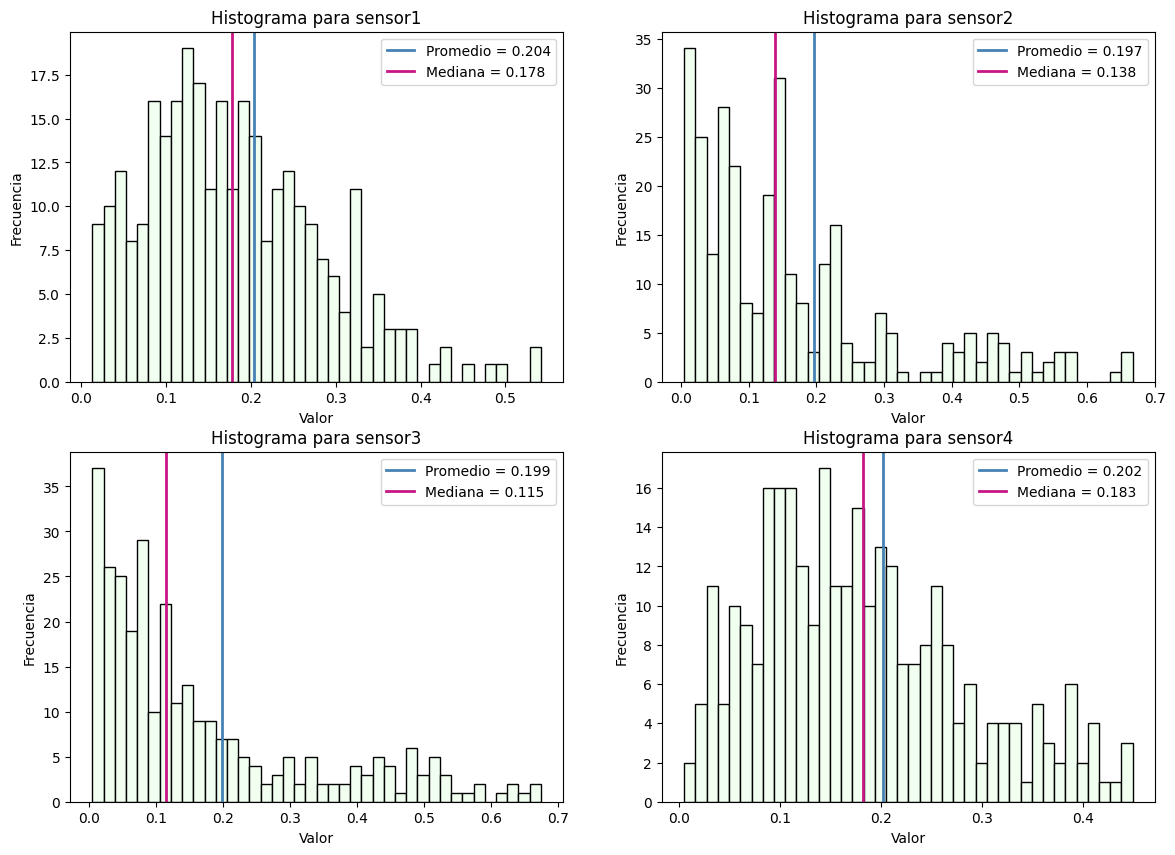

In [122]:
# aplicando primero log y luego standar scaler
df_logz = std_scaler.fit_transform(df_log)
df_logz = pd.DataFrame(df_logz , columns=df_log.columns)

# df con media y mediana
df_log_desc = df_logz.describe()
log_comparacion = pd.DataFrame({"promedio": dataframe.mean(),"mediana": dataframe.median()})

# columans a iterar
columnas = ["sensor1", "sensor2", "sensor3", "sensor4"]

plt.figure(figsize=(14, 10))

for i, col in enumerate(columnas, 1): # 1,sensor1;2,sensor2;...
    plt.subplot(2, 2, i)

    # histograma del sensor
    plt.hist(df_log[col], bins=40, edgecolor='black', color='honeydew') # bin = buckets o agrupamiento de datos en el hist

    # mean y q2 como lineas vert
    promedio = log_comparacion.loc[col, "promedio"]
    mediana = log_comparacion.loc[col, "mediana"]
    plt.axvline(promedio, color='steelblue', linewidth=2, label=f'Promedio = {promedio:.3f}') 
    plt.axvline(mediana, color='mediumvioletred', linewidth=2, label=f'Mediana = {mediana:.3f}')

    # textos
    plt.title(f"Histograma para {col}")
    plt.xlabel("Valor")
    plt.ylabel("Frecuencia")
    plt.legend()
    
plt.show()

## Box cox
"Es una técnica estadística que se utiliza para estabilizar la varianza y hacer que los datos se ajusten más a una distribución normal"

In [131]:
df_boxcox = df.copy()

lambdas = {}  

for col in df.columns:
    transformed, lam = boxcox(df[col])
    df_boxcox[col] = transformed
    lambdas[col] = lam
print("--- Boxcox antes de la estandarizacion: ---\n")
display(df_boxcox.describe(), lambdas)

scaler = StandardScaler()
df_final = scaler.fit_transform(df_boxcox)
df_final = pd.DataFrame(df_final, columns=df.columns)
print("--- Boxcox después de la estandarizacion: ---\n")
display(df_final.describe())

--- Boxcox antes de la estandarizacion: ---



,sensor1,sensor2,sensor3,sensor4
count,300.000000,300.000000,300.000000,300.000000
mean,-1.263703,-1.779057,-1.927235,-1.242512
std,0.356952,0.817806,0.954874,0.338268
min,-2.115594,-3.639731,-3.983070,-2.175426
25%,-1.499514,-2.276063,-2.633839,-1.476235
50%,-1.262996,-1.698922,-1.916240,-1.229455
75%,-1.005470,-1.229481,-1.271349,-0.997932
max,-0.310092,-0.051818,-0.038482,-0.507451


{'sensor1': np.float64(0.38250460092871397),
 'sensor2': np.float64(0.15770228237127984),
 'sensor3': np.float64(0.11399616274397927),
 'sensor4': np.float64(0.40480830418696906)}

--- Boxcox después de la estandarizacion: ---



,sensor1,sensor2,sensor3,sensor4
count,3.000000e+02,3.000000e+02,3.000000e+02,3.000000e+02
mean,9.473903e-17,-1.657933e-16,4.144833e-17,-1.065814e-16
std,1.001671e+00,1.001671e+00,1.001671e+00,1.001671e+00
min,-2.390557e+00,-2.279005e+00,-2.156588e+00,-2.762519e+00
25%,-6.617288e-01,-6.087462e-01,-7.412337e-01,-6.920948e-01
50%,1.982087e-03,9.815152e-02,1.153338e-02,3.866416e-02
75%,7.246473e-01,6.731363e-01,6.880295e-01,7.242440e-01
max,2.675998e+00,2.115570e+00,1.981317e+00,2.176642e+00


Al aplicar Boxcox podemos ver que los valores para los sensores se acercan más a la forma normal, la distribución ahora es más simétrica y comprimida <br>
Los valores lambdas encontrados por box cox son las potencias óptimas para que los datos se parezcan lo más posible a una distribución normal <br>
Después de aplicar estandarización a la box cox podemos ver que las variables quedaron en la misma escala yla forma original de la distribución se conserva, pero ahora con una media de 0 y una desviación estandar de 1 (cercanas)

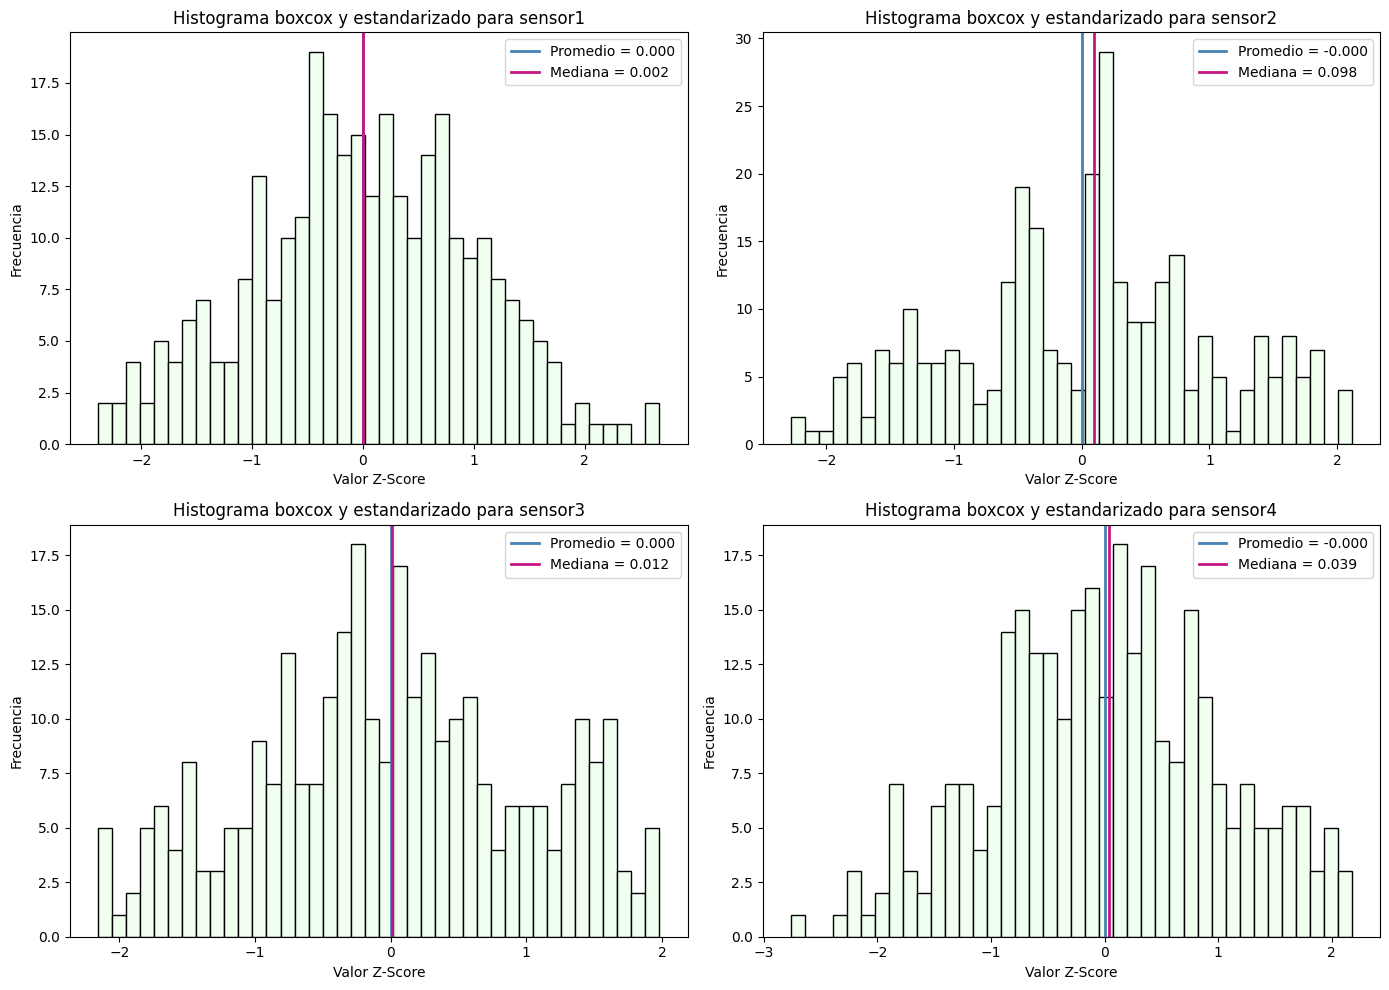

In [132]:
df_final_desc = df_final.describe()
final_comparacion = pd.DataFrame({
    "promedio": df_final.mean(),
    "mediana": df_final.median()
})

plt.figure(figsize=(14, 10))

for i, col in enumerate(columnas, 1):
    plt.subplot(2, 2, i)

    plt.hist(df_final[col], bins=40, edgecolor='black', color='honeydew')

    promedio = final_comparacion.loc[col, "promedio"]
    mediana = final_comparacion.loc[col, "mediana"]

    plt.axvline(promedio, color='steelblue', linewidth=2, 
                label=f'Promedio = {promedio:.3f}')
    plt.axvline(mediana, color='mediumvioletred', linewidth=2, 
                label=f'Mediana = {mediana:.3f}')

    plt.title(f"Histograma boxcox y estandarizado para {col}")
    plt.xlabel("Valor Z-Score")
    plt.ylabel("Frecuencia")
    plt.legend()

plt.tight_layout()
plt.show()


# Aprendizaje automático